## Summary

### Business understanding

Santader is a Spanish bank and one of the biggest banks in the world with more than 125 million customers. In our project we are analyzing our spanish customers and their behaviors within a year range. We will first analyze the data and extract meaning from and categorize to understand how Santander bank is being used by individuals. Afterwards we will train a model which better understands user and what potential product he/she has and what he/she is might be interested in. With this model we can better guide our potential customers with our services saving them time and also offer some of our product to our already existing customers.


#### Outline

1. Import neccessary packages and dataset
2. Explore data
3. Run Models
4. Conclusion

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc,roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC



%matplotlib inline

## EDA

#### Data Understanding

Our dataset is from Santander bank over 1.5 year of customer transactions starts at 2015-01-28 and the columns after ind_(xyz)_ult1 #25 is what customers buy and we will predict what will they buy after May 2016 for our test dataset. For our training dataset we have approximately 13m data points  and for test set we have 92 thousand data points.

#### Notes
 1. We have dropped the dataset to 10M rows after preprocessing
 2. We can see that most of our predictors are categorical data so it is not a good practice to reduce dimensionality with PCA

In [ ]:
df = pd.read_csv('preprocessed_train.csv')

In [ ]:
age = pd.read_csv('age.csv',header=None)

In [28]:
age = age.drop(0,axis=1)
age.head()

,1
0,35
1,23
2,23
3,22
4,23


In [29]:
df_all = df.join(age)

df_all.head()

,Unnamed: 0,date,customerid,employee_index,country_residence,gender,age,date_of_first_holder_contract,new_customer_index,customer_seniority,...,pensions_plan,loans,tax,credit_card,securities,home_account,payroll,pensions,direct_debit,1
0,0,2015-01-28,1375586,3,2,0,151,2015-01-12,0.0,263,...,0,0,0,0,0,0,0.0,0.0,0,35
1,1,2015-01-28,1050611,3,2,1,139,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,23
2,2,2015-01-28,1050612,3,2,1,139,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,23
3,3,2015-01-28,1050613,3,2,0,138,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,22
4,5,2015-01-28,1050615,3,2,0,139,2012-08-10,0.0,292,...,0,0,0,0,0,0,0.0,0.0,0,23


In [30]:
df_all = df_all.drop(['age','Unnamed: 0'],axis=1)
df_all.rename(columns={1:'age'},inplace=True)
df_all.head()

,Unnamed: 0,date,customerid,employee_index,country_residence,gender,date_of_first_holder_contract,new_customer_index,customer_seniority,primary_or_not,...,pensions_plan,loans,tax,credit_card,securities,home_account,payroll,pensions,direct_debit,1
0,0,2015-01-28,1375586,3,2,0,2015-01-12,0.0,263,1.0,...,0,0,0,0,0,0,0.0,0.0,0,35
1,1,2015-01-28,1050611,3,2,1,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,23
2,2,2015-01-28,1050612,3,2,1,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,23
3,3,2015-01-28,1050613,3,2,0,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,22
4,5,2015-01-28,1050615,3,2,0,2012-08-10,0.0,292,1.0,...,0,0,0,0,0,0,0.0,0.0,0,23


#### Analyzing by visuals

We will have a look at some of the obvious characteristic of humans and their relations to out target variables to have a sense of our business case.

We will analyze

1. By Age groups
2. By Gender
3. Residency
4. Income group


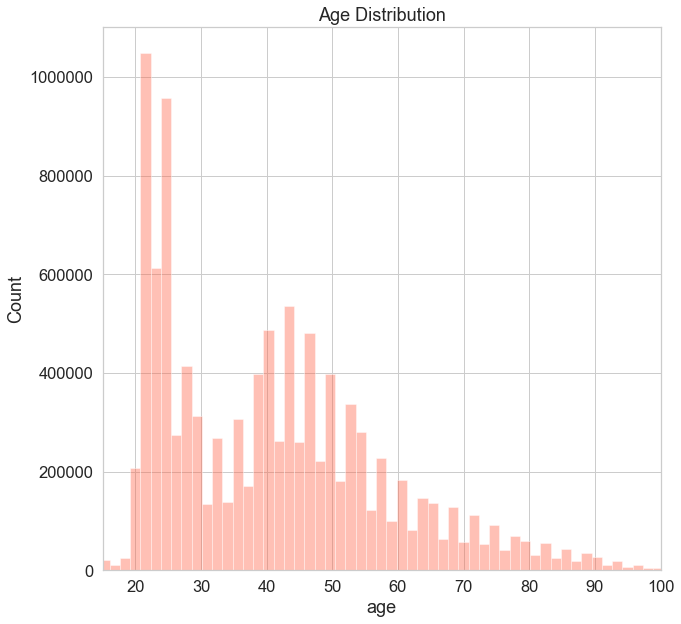

In [89]:
with sns.plotting_context("notebook",font_scale=1.5):
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    sns.distplot(df_all["age"],
                 bins=80,
                 kde=False,
                 color="tomato")
    plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100))

In [183]:
df_all['AgeCat'] = pd.cut(df_all.age, bins=np.linspace(df_all.age.min()-1, df_all.age.max(), 11))
df_all['AgeCat'] = df_all['AgeCat'].astype(str)

In [184]:
normalize_vals = df_all['AgeCat'].value_counts()
age_category = df_all.groupby('AgeCat').sum()

In [193]:
normalize_df = pd.DataFrame([normalize_vals.index,normalize_vals]).T

In [186]:
age_category.drop(age_category.iloc[0:1,:21].columns,axis=1,inplace=True)
age_category.drop('age',axis=1,inplace=True)

In [194]:
# WE are going to normalize each age categories behavior according to their number

normalize_df.rename({0:'cat',1:'number'},axis=1,inplace=True)
normalize_df.number = normalize_df.number.astype(int)


,cat,number
0,"(13.6, 26.2]",3167065
1,"(38.8, 51.4]",3038977
2,"(26.2, 38.8]",1932641
3,"(51.4, 64.0]",1480858
4,"(64.0, 76.6]",683632
5,"(76.6, 89.2]",337835
6,"(89.2, 101.8]",87045
7,"(1.0, 13.6]",59120
8,"(101.8, 114.4]",8066
9,"(114.4, 127.0]",153


In [238]:
df_new = pd.DataFrame()
for ind in age_category.index:
    normalizer = int(normalize_df[normalize_df['cat'] == ind ]['number'])
    ser = age_category.loc[ind].div(normalizer,axis=0)
    df_new = df_new.append(ser.T,ignore_index=False)

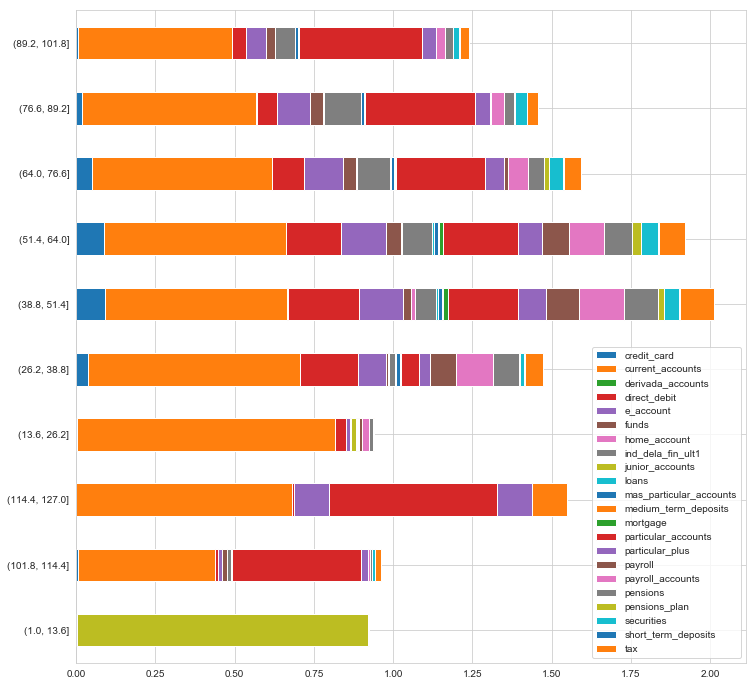

In [254]:

df_new.plot(kind='barh',stacked=True,figsize=(12,12))

### Age related analysis

A current-acccount is a product that is used by each age group which is basically
The age group which buys most the product is between 38-51 years old. This graph is weighted with their total number of customers. So we can see which age group uses which product the most. Mortgage is more popular after age 38-64.

In [92]:
# Get our target variable dataset
target = df_all.iloc[:,21:].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a71b56c50>,
      dtype=object)

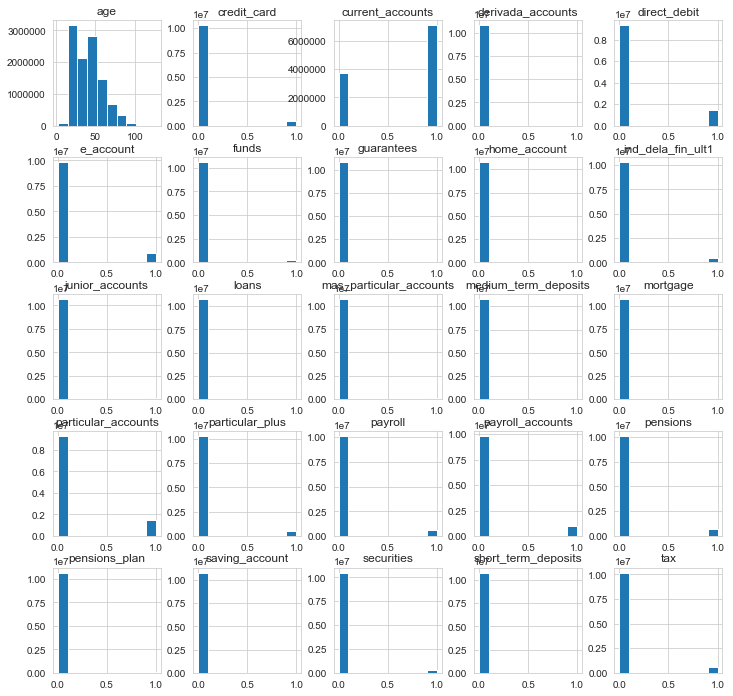

In [252]:
target.hist(figsize=(12,12))

### Gender

In [247]:
province = sorted(df_all.groupby('province_name')['gross_income'].median())
gender = df_all.groupby('gender')['gross_income'].median()
uniquecust = df_all.groupby('customerid').sum()

In [248]:
uniquecust = uniquecust.iloc[:,20:]

/Users/kaanbursa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


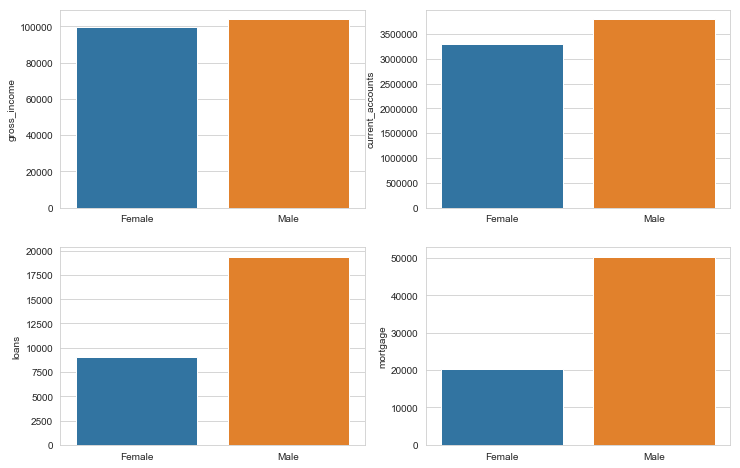

In [297]:
plt.figure(figsize=(12,8))
plt.subplot(224)

ax1 = plt.subplot(221)
gender = df_all.groupby('gender')['gross_income'].median()
sns.barplot(['Female','Male'],gender, ax=ax1)

ax2 = plt.subplot(222)
gencur = df_all.groupby('gender')['current_accounts'].sum()
sns.barplot(['Female','Male'],gencur,ax=ax2)

ax3 = plt.subplot(223)
loans = df_all.groupby('gender')['loans'].sum()
sns.barplot(['Female','Male'],loans,ax=ax3)

ax4 = plt.subplot(224)
mortgage = df_all.groupby('gender')['mortgage'].sum()
sns.barplot(['Female','Male'],mortgage,ax=ax4)

### Gender Based analysis

We can see the characteristic of genders and their behavoir. 

In [263]:
# Visualizing the class imbalance for the target vectors
# Most of our target vars is imbalanced only currenct acocunt is column is better balanced
imbalance_dict = {}
for col in target.columns[:-1]:
    f,t = target[col].value_counts()
    imbalance_dict[col] = [f /  (f + t),t / (f + t)]
    
imbalance_dict

{'saving_account': [0.9998843024875799, 0.00011569751242011406],
 'guarantees': [0.9999727661580052, 2.7233841994806673e-05],
 'current_accounts': [0.656235549389962, 0.3437644506100381],
 'derivada_accounts': [0.9995790796665837, 0.0004209203334163317],
 'payroll_accounts': [0.9117315054423221, 0.08826849455767795],
 'junior_accounts': [0.9896726306927993, 0.010327369307200702],
 'mas_particular_accounts': [0.9907558706529601, 0.009244129347039923],
 'particular_accounts': [0.8615510210282313, 0.1384489789717687],
 'particular_plus': [0.9528785059403123, 0.04712149405968769],
 'short_term_deposits': [0.9983355861463854, 0.0016644138536145792],
 'medium_term_deposits': [0.9982283181564875, 0.0017716818435124912],
 'ind_dela_fin_ult1': [0.9531697413118486, 0.04683025868815139],
 'e_account': [0.9100142912827992, 0.08998570871720082],
 'funds': [0.9800243474252718, 0.01997565257472818],
 'mortgage': [0.9934516504819835, 0.006548349518016576],
 'pensions_plan': [0.9898289010718647, 0.0101

## Modeling

1. Decision Tree
2. KNN
3. Random Forest
4. Random Forest twitching with XGboost
5. Support Vector Machines
6. Ensemble Method

In [264]:
subsample = df_all.sample(frac=0.05, random_state=1)

In [267]:
target_sub = subsample['current_accounts']

In [272]:
subsample = subsample.iloc[:,:21]